# Домашнее задание №3. Линейная регрессия: переобучение и регуляризация

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [3]:
fn = "https://github.com/nadiinchi/iad2019/raw/master/materials/bikes_rent.csv"
df = pd.read_csv(fn)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12 (соответственно январь---декабрь)
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6 (соответственно понедельник---воскресенье)
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. Давайте посмотрим на графиках, как целевой признак зависит от остальных

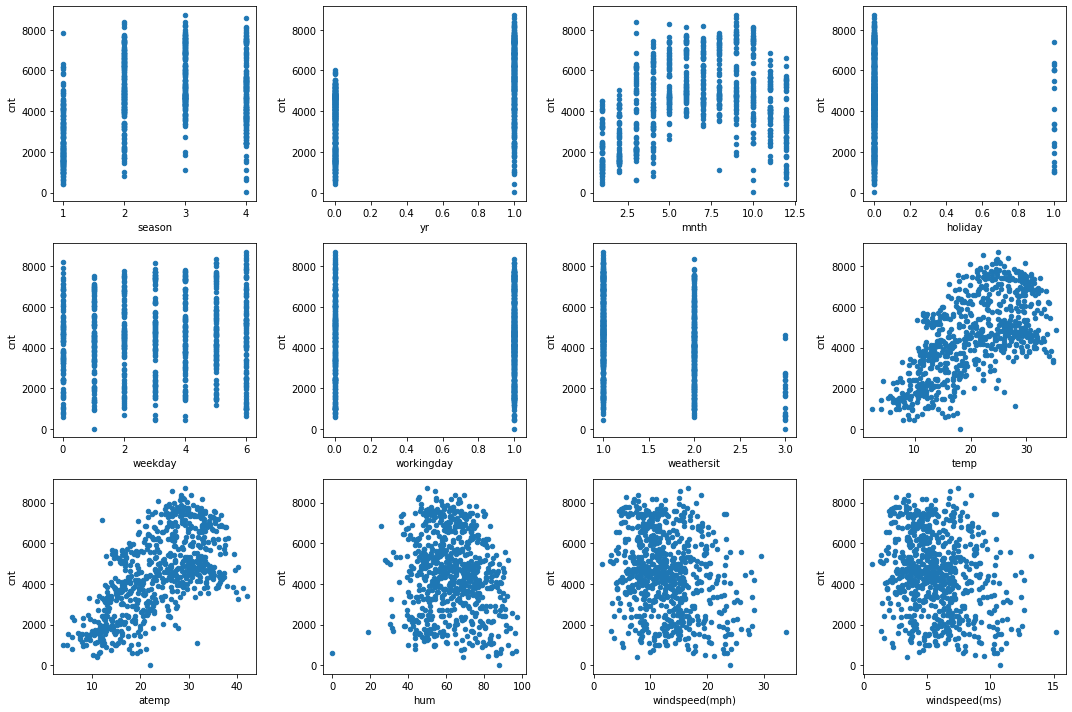

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])
plt.tight_layout()

__Блок 1. Ответьте на вопросы (каждый 0.25 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: Зависимость нелинейная: количество арендованных велосипедов увеличивается к летним месяцам (6-8) и затем сокращается вновь
1. В какие дни: рабочие или выходные, людям чаще нужен велосипед?
   * ответ: Различия в разбросах значений незначительны между рабочими и выходными днями - следовательно, велосипед нужен людям приблизительно одинаково, что в выходные, что в рабочие дни. Однако, график плотнее в субботу и воскресенье,что может указывать на небольшое превосходство выходных дней над рабочими в спросе на велосипеды
1. Укажите одну переменную, которая не влияет на cnt.
   * ответ: workingday
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: temp, atemp

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [4]:
# Считаем корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df.loc[:, df.columns != 'cnt'].corrwith(df["cnt"])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, это говорит в пользу использования линейных методов.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [5]:
# Считаем попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt с помощью метода corr:
df.loc[:, df.columns[7:]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


В матрице имеются две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Этот факт негативно сказывается на обучении линейной модели в силу мультиколлинеарности.

Посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли единиц у бинарных признаков.

In [4]:
df.loc[:, df.columns != 'cnt'].mean()

season             2.496580
yr                 0.500684
mnth               6.519836
holiday            0.028728
weekday            2.997264
workingday         0.683995
weathersit         1.395349
temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Попробуем обучить самую простую линейную регрессию
А именно, построим зависимость cnt от atemp

In [6]:
from sklearn.linear_model import LinearRegression

In [8]:
linspace = np.linspace(0, 40, 1000)[:, np.newaxis]
X_train = np.array(df["atemp"]).reshape((-1, 1))
y_train = df["cnt"]
X_test = linspace
model1 = LinearRegression().fit(X_train,y_train)
y_test = model1.predict(X_test)

array([ 945.8239811 ,  951.83145573,  957.83893037,  963.846405  ,
        969.85387964,  975.86135427,  981.8688289 ,  987.87630354,
        993.88377817,  999.89125281, 1005.89872744, 1011.90620208,
       1017.91367671, 1023.92115134, 1029.92862598, 1035.93610061,
       1041.94357525, 1047.95104988, 1053.95852451, 1059.96599915,
       1065.97347378, 1071.98094842, 1077.98842305, 1083.99589769,
       1090.00337232, 1096.01084695, 1102.01832159, 1108.02579622,
       1114.03327086, 1120.04074549, 1126.04822013, 1132.05569476,
       1138.06316939, 1144.07064403, 1150.07811866, 1156.0855933 ,
       1162.09306793, 1168.10054257, 1174.1080172 , 1180.11549183,
       1186.12296647, 1192.1304411 , 1198.13791574, 1204.14539037,
       1210.15286501, 1216.16033964, 1222.16781427, 1228.17528891,
       1234.18276354, 1240.19023818, 1246.19771281, 1252.20518745,
       1258.21266208, 1264.22013671, 1270.22761135, 1276.23508598,
       1282.24256062, 1288.25003525, 1294.25750988, 1300.26498

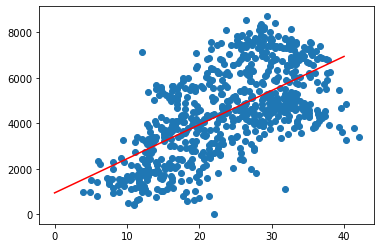

In [9]:
plt.scatter(df["atemp"], df["cnt"])
plt.plot(linspace.ravel(), y_test, c='r')

У вас должна получиться прямая, проходящая через изображенные точки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков

In [10]:
from sklearn.preprocessing import scale

In [11]:
X = scale(df[df.columns[:-1]])
y = df["cnt"]

Давайте обучим линейную регрессию на полных данных и посмотрим на веса признаков.

In [12]:
model2 = LinearRegression().fit(X,y)
coefs = model2.coef_
weights = list(zip(df.columns,coefs))
print(*weights, sep='\n')

('season', 570.8705744929921)
('yr', 1021.959184453726)
('mnth', -141.30502511524503)
('holiday', -86.75744720349323)
('weekday', 137.22662551096067)
('workingday', 56.3910061965351)
('weathersit', -330.2310362473084)
('temp', 367.49202357022045)
('atemp', 585.5369115245651)
('hum', -145.60912610327284)
('windspeed(mph)', 12457934448658.908)
('windspeed(ms)', -12457934448857.361)


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу $||Xw-y||$ прибавляют L1 (Lasso) или L2 (Ridge) норму весов, умноженную на коэффициент регуляризации $\alpha$.

In [13]:
from sklearn.linear_model import Ridge, Lasso

In [14]:
# Обучаем линейную модель с L1-регуляризацией
L1 = Lasso().fit(X,y)
coefs2 = L1.coef_
weights2 = list(zip(df.columns,coefs2))
print(*weights2, sep='\n')

('season', 560.241616030886)
('yr', 1019.4634940657194)
('mnth', -128.73062703678696)
('holiday', -86.1527813337109)
('weekday', 137.34789390496314)
('workingday', 55.21237064135692)
('weathersit', -332.36985696234854)
('temp', 376.36323620969824)
('atemp', 576.5307935045514)
('hum', -144.12915500348586)
('windspeed(mph)', -197.13968940249427)
('windspeed(ms)', -2.8041280611694017e-08)


In [15]:
# Обучаем линейную модель с L2-регуляризацией
L2 = Ridge().fit(X,y)
coefs3 = L2.coef_
weights3 = list(zip(df.columns,coefs3))
print(*weights3, sep='\n')

('season', 563.0645722520144)
('yr', 1018.9483787875288)
('mnth', -131.8733202824729)
('holiday', -86.74609799709246)
('weekday', 138.00511117871912)
('workingday', 55.90311037506469)
('weathersit', -332.3497884990733)
('temp', 386.45788919190437)
('atemp', 566.347047060071)
('hum', -145.0713272986728)
('windspeed(mph)', -99.25944108182254)
('windspeed(ms)', -99.25944115430993)


Регуляризация привносит в модель дополнительную информацию об ограничениях решения. Мультиколлинеарность может способствовать переобучению, привнося в модель малозначимые данные; регуляризация будет штрафовать большие веса, таким образом снижая влияние мультиколлинеарных признаков на предсказываемые результаты

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках (всё из-за ромбообразных линий уровня L1-нормы).

Пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$. 

In [16]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучаем регрессор Lasso
# и записываем веса в соответствующую строку матрицы coefs_lasso,
# а затем обучаем Ridge и запишите веса в coefs_ridge.
for i in range(len(alphas)):
    model = Lasso(alpha = alphas[i])
    model.fit(X, y)
    coefs_lasso[i] = model.coef_
    
for i in range(len(alphas)):
    model = Ridge(alpha = alphas[i])
    model.fit(X, y)
    coefs_ridge[i] = model.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

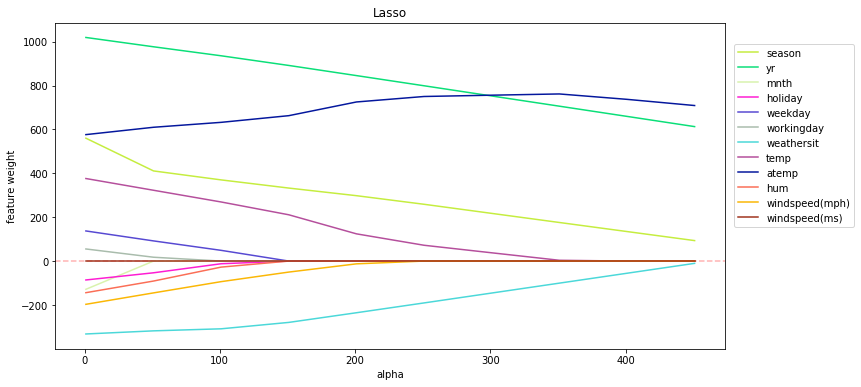

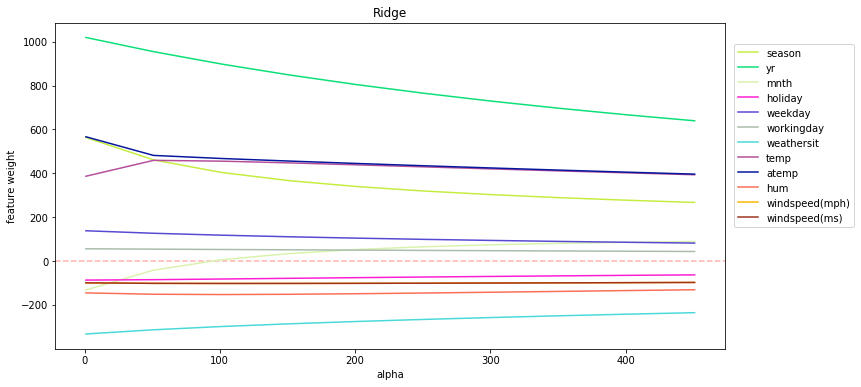

In [17]:
colors = [np.random.rand(3) for x in range(X.shape[1])]

plt.figure(figsize=(12, 6))
plt.axhline(y=0, c='r', linestyle='--', alpha=.3)
for i, (coef, feature) in enumerate(zip(coefs_lasso.T, df.columns)):
    plt.plot(alphas, coef, label=feature, color=colors[i])
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(12, 6))
plt.axhline(y=0, c='r', linestyle='--', alpha=.3)
for i, (coef, feature) in enumerate(zip(coefs_ridge.T, df.columns)):
    plt.plot(alphas, coef, label=feature, color=colors[i])
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")
plt.show()

1. Какой регрессор (Ridge или Lasso) агрессивнее уменьшает веса?
    * Ответ: Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: Они обнулятся. Lasso стремится исключать пики, приближая модель к более линейному виду, поэтому по мере увеличения значения alpha, все больше весов будут ею "сглаживаться" в ноль
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha? А Ridge?
    * Ответ: Да, можно. Lasso обнуляет windspeed(ms) уже на стандартных параметрах функции. На графике показано, что значение коэффициента для windspeed(ms) совпадает с нулевым уравнем. Ridge делает иначе, сохраняя для этого предиктора малый коэффициент
1. Какой из регрессоров подойдет для отбора неинформативных признаков?
    * Ответ: Lasso, поскольку позволит однозначно избавиться от неинформативного признака

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

In [18]:
from sklearn.linear_model import LassoCV

In [19]:
# Обучаем регрессор LassoCV на всех параметрах регуляризации из alpha
 
alphas = np.arange(1, 100, 5)
mf = LassoCV(cv = 3, alphas=alphas).fit(X, y) #final model
mse_mean = np.mean(mf.mse_path_, axis=1)
hy = mse_mean[list(mf.alphas_).index(mf.alpha_)]

Text(0.5, 1.0, 'LassoCV')

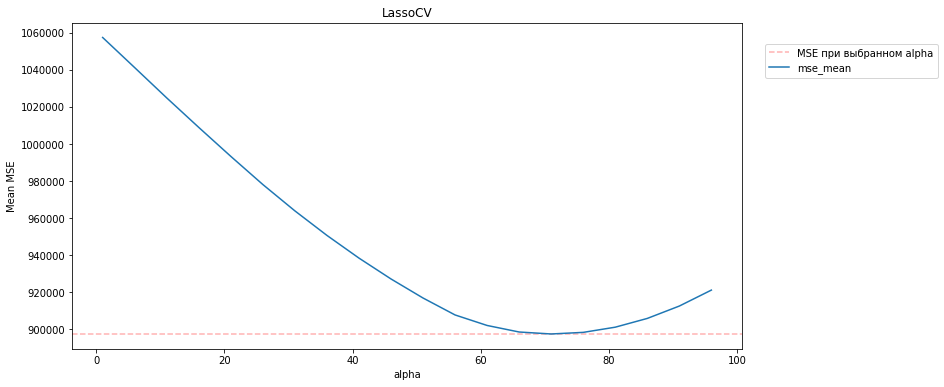

In [20]:
# Строим график _усредненного_ по строкам MSE в зависимости от alpha.

plt.figure(figsize=(12, 6))
plt.axhline(y=hy, c='r', linestyle='--', alpha=.3, label = "MSE при выбранном alpha")
plt.plot(mf.alphas_,mse_mean, label = "mse_mean")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.95))
plt.xlabel("alpha")
plt.ylabel("Mean MSE")
plt.title("LassoCV")

In [21]:
# Выводим выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
print("Выбранное альфа = ", mf.alpha_, "\n")
weights4 = list(zip(df.columns,mf.coef_))
print(*weights4, sep='\n')

Выбранное альфа =  26 

('season', 431.50501463394625)
('yr', 997.5949579859106)
('mnth', -0.0)
('holiday', -71.47585346746395)
('weekday', 113.41239026287381)
('workingday', 36.831355314954465)
('weathersit', -323.67910842163866)
('temp', 348.3123978409412)
('atemp', 599.3914909821128)
('hum', -122.41739716302786)
('windspeed(mph)', -170.44942053622722)
('windspeed(ms)', -2.2574798165783592e-08)


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Значения alpha, соответствующие минимумам MSE на каждом разбиении:  [ 725129.98859493  625492.4295994  1232891.04325771]


Text(0.5, 1.0, 'Lasso: третье разбиение')

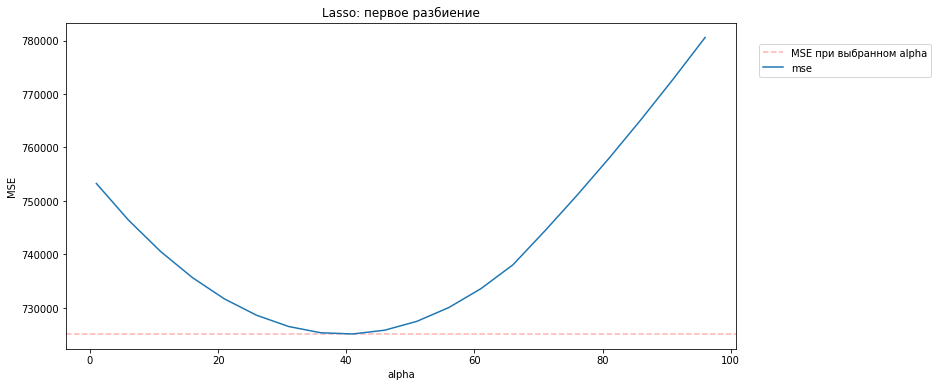

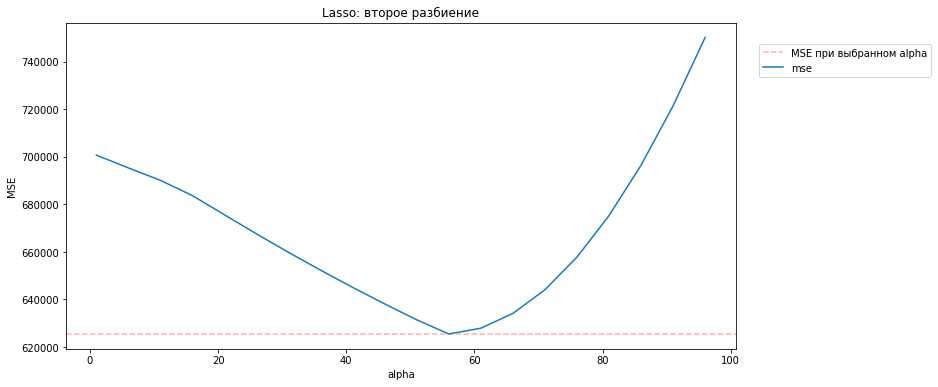

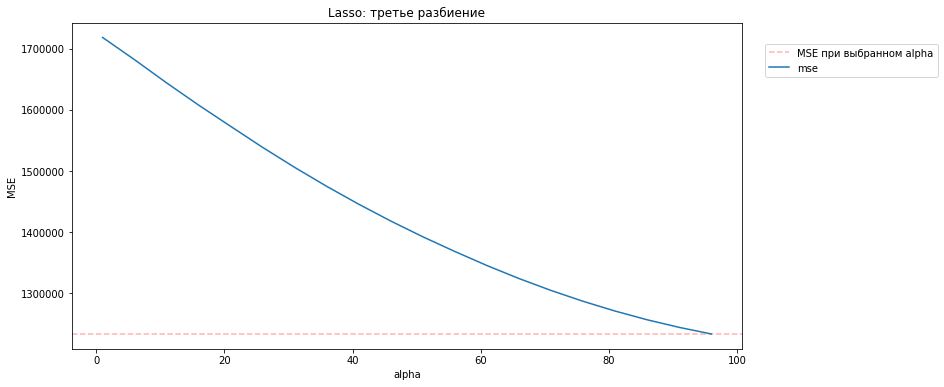

In [66]:
# Выводим значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
min_mse = np.min(mf.mse_path_, axis = 0)
print("Значения alpha, соответствующие минимумам MSE на каждом разбиении: ", min_mse)

plt.figure(figsize=(12, 6))
plt.axhline(y=min_mse[0], c='r', linestyle='--', alpha=.3, label = "MSE при выбранном alpha")
plt.plot(alphas,mf.mse_path_[:,0], label = "mse")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("Lasso: первое разбиение")

plt.figure(figsize=(12, 6))
plt.axhline(y=min_mse[1], c='r', linestyle='--', alpha=.3, label = "MSE при выбранном alpha")
plt.plot(alphas,mf.mse_path_[:,1], label = "mse")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("Lasso: второе разбиение")

plt.figure(figsize=(12, 6))
plt.axhline(y=min_mse[2], c='r', linestyle='--', alpha=.3, label = "MSE при выбранном alpha")
plt.plot(alphas,mf.mse_path_[:,2], label = "mse")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("Lasso: третье разбиение")

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами, посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: Таковыми признаками являются yr, atemp, temp, season (в порядке убывания абсолютных значений коэффициентов). Утверждать линейную зависимость для года нерационально: во-первых, в выборке присутствуют всего два года, чего мало для полноценного вывода; во-вторых, изменения по годам обусловлены на самом деле не годом, а прочими признаками, изменяющимися во времени (возможно, со временем увеличивается температура, но сам год в этом никак не виноват). Для объективного значения температуры и значения температуры по ощущениям линейную зависимость судя по графикам утверждать можно, и это осмысленное утверждение: чем выше температура, тем больше людям а) комфортно кататься б)хочется развеяться на свежем воздухе. Для season зависимость на самом деле нелинейная: с приходом теплых месяцев спрос на велосипеды повышается, а затем вновь падает по мере наступления осени; так, в каждом году сначала спрос низкий, затем возрастает и вновь сокращается вслед за изменениям температуры. Следовательно, общий знаменатель всех этих переменных - температура, и только с ней существует реальная линейная зависимость.
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами, посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: Таковыми признаками являются weathersit, hum, holiday (в порядке убывания абсолютных значений коэффициентов). Для благоприятности погоды убывающая нейная зависимость наблюдается: чем выше значение переменной (т.е. чем хуже погода) тем меньше спрос на аренду велосипедов. Для hum убывающая зависимость выражена не так ярко, однако тоже наблюдается: с повышением влажности воздуха постепенно падает спрос на велосипеды. Для праздников зависимость тоже есть: в непраздничные дни, закодированные как 0, спрос на велосипеды значительно выше, чем в праздничные, закодированные как 1.
1. Выберите признаки с нулевыми коэффициентами. Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: Признаком с нулевым коэффициентом стал mnth - месяц. Зануление этой переменной может быть связано с тем, что она по сути дублирует переменную season, выражая ту же нелинейную зависимость. Сказать, что она никак не влияет на спрос на велосипеды нельзя, однако это переменная-дублер для времени года, поэтому иметь их вместе в модели не представляет смысла. 